In [0]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as kp_image
import tensorflow as tf
from matplotlib import pyplot as plt
from google.colab import files

import  tensorflow as tf
from tensorflow.keras import models
import tensorflow.contrib.eager as tfe

import IPython.display
from typing import Dict, Tuple, List
import time
import os

def load_image(image_path: str, dimension=512) -> np.ndarray:
  max_dim = 512
  img = Image.open(image_path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # Add one dimension for batches
  img = np.expand_dims(img, axis=0)
  return img

def display_image(image: np.ndarray) -> None:
	image = np.squeeze(image, axis=0)
	image = image.astype("uint8")
	plt.imshow(image)
	plt.show()

def preprocess_image(image: np.ndarray) -> np.ndarray:
	new_img = tf.keras.applications.vgg19.preprocess_input(image)
	return new_img

def prepare_image_visualization(image: np.ndarray) -> np.ndarray:
	if len(image.shape) == 4:
		image = np.squeeze(image, 0)
	image_copy = image.copy()
	image_copy[:, :, 0] += 103.939
	image_copy[:, :, 1] += 116.779
	image_copy[:, :, 2] += 123.68
	image_copy = image_copy[:, :, ::-1] # VGG preprocess step tranforms RGB -> BGR
	image_copy = np.clip(image_copy, 0, 255).astype('uint8')
	return image_copy

def compute_gram_matrix(feature_map: np.ndarray) -> np.ndarray:
	num_channels = int(feature_map.shape[-1])
	feature_map = tf.reshape(feature_map, (-1, num_channels))
	length = tf.shape(feature_map)[0]
	gram_matrix = tf.matmul(tf.transpose(feature_map), feature_map)
	gram_matrix = gram_matrix / tf.cast(length, tf.float32)
	return gram_matrix

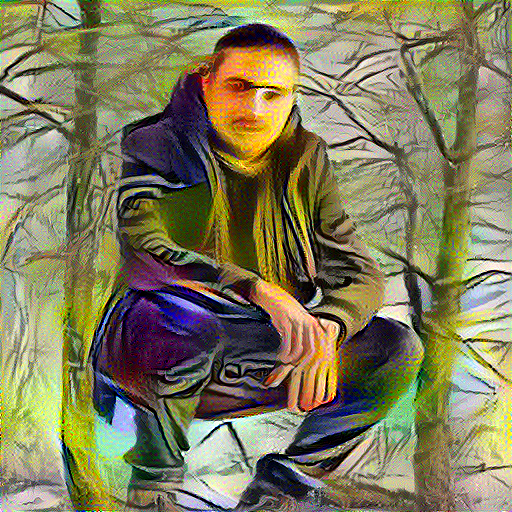

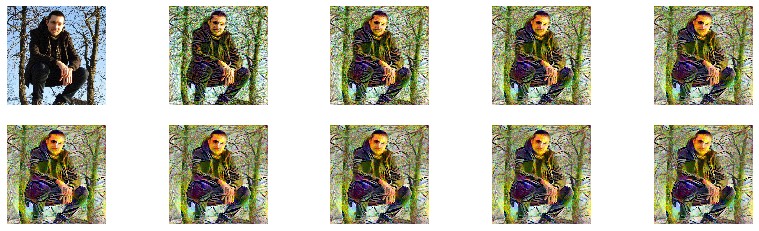

In [0]:

tf.enable_eager_execution()

STYLE_LAYERS = [
	"block1_conv1",
	"block2_conv1",
	"block3_conv1", 
	"block4_conv1", 
	"block5_conv1"
]

CONTENT_LAYERS = [
	"block5_conv2"
]


def get_intermediate_layers_model(layers: Dict) -> models.Model:
	vgg_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
	vgg_model.trainable = False # Freeze the weights

	style_layer_outputs = [vgg_model.get_layer(layer_name).output for layer_name in layers["style_layers"]]
	content_layer_outputs = [vgg_model.get_layer(layer_name).output for layer_name in layers["content_layers"]]
	all_outputs = style_layer_outputs + content_layer_outputs

	new_model = models.Model(vgg_model.input, all_outputs)
	for layer in new_model.layers:
		layer.trainable = False
	return new_model


def compute_content_loss(generated_layer, target_content_layer):
	return tf.reduce_mean(tf.square(generated_layer - target_content_layer))


def compute_style_loss(generated_layer_style, targeted_style_gram):
	generated_layer_style_gram = compute_gram_matrix(generated_layer_style)
	return tf.reduce_mean(tf.square(generated_layer_style_gram - targeted_style_gram))

def compute_total_loss(model, style_representations_gram_matrix, content_representations, generated_image, loss_weights) -> Tuple:
	generated_representations = model(generated_image)
	generated_content_representations = generated_representations[len(STYLE_LAYERS):]
	generated_style_representations = generated_representations[:len(STYLE_LAYERS)]

	style_loss = 0
	content_loss = 0
	style_weight, content_weight = loss_weights

	weight_style_layer = 1.0 / float(len(STYLE_LAYERS))
	for target_style, gen_style in zip(style_representations_gram_matrix, generated_style_representations):
		style_loss += weight_style_layer * compute_style_loss(gen_style[0], target_style)

	weight_content_layer = 1.0 / float(len(CONTENT_LAYERS))
	for target_content, gen_content in zip(content_representations, generated_content_representations):
		content_loss += weight_content_layer * compute_content_loss(gen_content[0], target_content)

	style_loss *= style_weight
	content_loss *= content_weight
	total_loss = style_loss + content_loss
	return total_loss, style_loss, content_loss

def compute_grads(model, style_representations_gram_matrix, content_representations, generated_image, loss_weights):
	with tf.GradientTape() as tape: 
		all_loss = compute_total_loss(
			model, 
			style_representations_gram_matrix, 
			content_representations, 
			generated_image, 
			loss_weights
		)

	total_loss = all_loss[0]
	return tape.gradient(total_loss, generated_image), all_loss


def transfer_style(content_image, style_image, learning_rate=5, content_weight=1e3, style_weight=1e-2, num_iterations=100):
	model = get_intermediate_layers_model({
		"style_layers": STYLE_LAYERS,
		"content_layers": CONTENT_LAYERS
	})

	# Get intermediate representations for the content image and the style image
	content_image = preprocess_image(content_image)
	style_image = preprocess_image(style_image)
	
	content_representations = model(content_image)
	style_representations = model(style_image)

	content_representations = [layer[0] for layer in content_representations[len(STYLE_LAYERS):]]
	style_representations_gram_matrix = [compute_gram_matrix(layer[0]) for layer in style_representations[:len(STYLE_LAYERS)]]

	# Create the generated image
	generated_image = np.copy(content_image)
	generated_image = tfe.Variable(generated_image, dtype=tf.float32)
	
	optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.99, epsilon=1e-1)
	loss_weights = (style_weight, content_weight)
	best_loss, best_img = float('inf'), None

	# For displaying grid
	num_rows = 2
	num_cols = 5
	display_interval = num_iterations/(num_rows * num_cols)
	start_time = time.time()
	global_start = time.time()

	norm_means = np.array([103.939, 116.779, 123.68])
	min_vals = -norm_means
	max_vals = 255 - norm_means 

	imgs = []
	for i in range(num_iterations):
		grads, all_loss = compute_grads(
			model, 
			style_representations_gram_matrix, 
			content_representations, 
			generated_image, 
			loss_weights
		)

		loss, style_score, content_score = all_loss
		optimizer.apply_gradients([(grads, generated_image)])
		clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
		generated_image.assign(clipped)
		end_time = time.time() 

		if loss < best_loss:
			# Save the image with the best score(smallest total loss) 
			best_loss = loss
			best_img = prepare_image_visualization(generated_image.numpy())

		if i % display_interval== 0:
			start_time = time.time()

			plot_img = generated_image.numpy()
			plot_img = prepare_image_visualization(plot_img)
			imgs.append(plot_img)
			IPython.display.clear_output(wait=True)
			IPython.display.display_png(Image.fromarray(plot_img))
			print('Iteration: {}'.format(i))        
			print('Total loss: {:.4e}, ' 
					'style loss: {:.4e}, '
					'content loss: {:.4e}, '
					'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
	print('Total time: {:.4f}s'.format(time.time() - global_start))
	IPython.display.clear_output(wait=True)
	plt.figure(figsize=(14,4))
	for i,img in enumerate(imgs):
		plt.subplot(num_rows,num_cols,i+1)
		plt.imshow(img)
		plt.xticks([])
		plt.yticks([])

	return best_img, best_loss  


def main(args):
	img_dir = '/tmp/nst'
	if not os.path.exists(img_dir):
		os.makedirs(img_dir)
    
	uploaded = files.upload()
	content_path = f'/content/{list(uploaded.keys())[0]}'
    
	uploaded = files.upload()
	style_path = f'/content/{list(uploaded.keys())[0]}'

	content_image = load_image(content_path)
	style_image = load_image(style_path)

	best_img, best_loss = transfer_style(
		content_image, 
		style_image, 
		learning_rate=args["learning_rate"], 
		num_iterations=args["iterations"]
	)

	img = Image.fromarray(best_img)
	img.save('my.png')
	IPython.display.display_png(img)


args = {"learning_rate":5, "iterations": 1000}
main(args)